In [1]:
import os
os.chdir('G:\\freecloud\\ThinkpadC_space\\Desktop\\资料\\资料\\量化投资：以Python为工具\\Python Quant Book\\part 5\\034')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
TsingTao=pd.read_csv('TsingTao.csv',index_col='Date')
TsingTao.index=pd.to_datetime(TsingTao.index)
TsingTao.Volume=TsingTao.Volume.replace(0,np.nan)
TsingTao=TsingTao.dropna()
close=TsingTao.Close
Volume=TsingTao.Volume

In [4]:
difClose=close.diff()
difClose[0]=0
OBV=(((difClose>=0)*2-1)*Volume).cumsum()
OBV.name='OBV'
OBV.head()

Date
2014-01-02    2592800.0
2014-01-03    1032100.0
2014-01-06    -828800.0
2014-01-07   -3763200.0
2014-01-08   -1962800.0
Name: OBV, dtype: float64

In [5]:
OBV.describe()

count    3.230000e+02
mean    -1.104009e+07
std      3.572700e+07
min     -6.132070e+07
25%     -3.602440e+07
50%     -2.539030e+07
75%      1.912695e+07
max      9.652380e+07
Name: OBV, dtype: float64

In [6]:
import movingAverage as mv
smOBV=mv.smaCal(OBV,9)
smOBV.tail()

Date
2015-04-24    7.677104e+07
2015-04-27    7.864432e+07
2015-04-28    8.023227e+07
2015-04-29    8.173780e+07
2015-04-30    8.144052e+07
dtype: float64

In [7]:
AdjOBV=((close-TsingTao.Low)-(TsingTao.High-close)\
         )/(TsingTao.High-TsingTao.Low)*Volume
AdjOBV.name='AdjOBV'
AdjOBV.head()

Date
2014-01-02   -3.241000e+05
2014-01-03   -2.392314e+05
2014-01-06   -1.606418e+06
2014-01-07    6.852790e+05
2014-01-08    2.864273e+05
Name: AdjOBV, dtype: float64

In [8]:
AdjOBVd=AdjOBV.cumsum()
AdjOBVd.name='AdjOBVd'
AdjOBVd.describe()

count    3.230000e+02
mean     4.242572e+07
std      4.706378e+07
min     -1.589447e+07
25%     -5.944451e+05
50%      3.387219e+07
75%      8.573505e+07
max      1.589280e+08
Name: AdjOBVd, dtype: float64

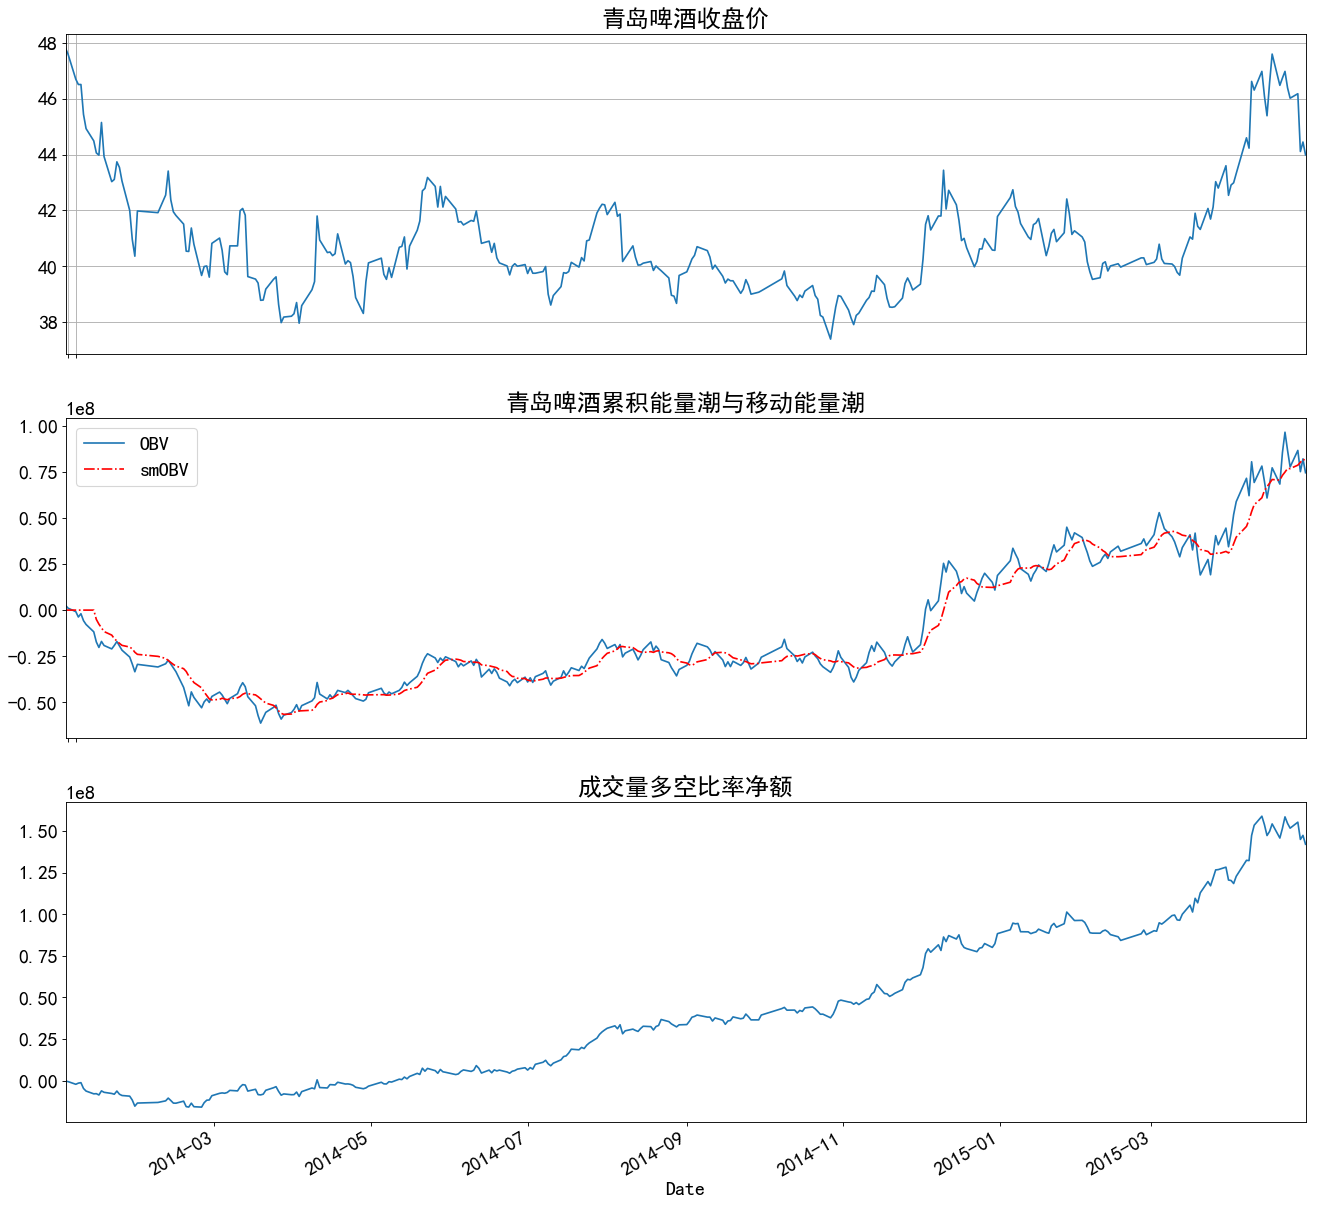

In [13]:
plt.figure(figsize=(20,20),dpi=80)
plt.rc('font', family='SimHei', size=18)
import matplotlib
matplotlib.rcParams['axes.unicode_minus']=False
ax1=plt.subplot(3,1,1)
close.plot(title='青岛啤酒收盘价')
plt.xticks(close.index[1:3],(''))
plt.xlabel('')
ax2=plt.subplot(3,1,2)
OBV.plot(label='OBV',title='青岛啤酒累积能量潮与移动能量潮')
smOBV.plot(label='smOBV',linestyle='-.',color='r')
plt.legend(loc='upper left')
plt.xticks(close.index[1:3],(''))
plt.xlabel('')
ax3=plt.subplot(3,1,3)
AdjOBVd.plot(title='成交量多空比率净额')
for ax in ax1,ax2,ax3:
    ax.grid(True)
    plt.show()

In [14]:
import ffn
def trade(obv,price):
    signal=(2*(obv.diff()>0)-1)[1:]
    ret=ffn.to_returns(price)[1:]
    ret.name='ret'
    tradeRet=ret*signal.shift(1)
    tradeRet.name='tradeRet'
    Returns=pd.merge(pd.DataFrame(ret),\
                     pd.DataFrame(tradeRet),\
                    left_index=True,right_index=True).dropna()
    return(Returns)

In [15]:
OBVtrade=trade(OBV,close)
OBVtrade.head()

,ret,tradeRet
Date,,
2014-01-06,-0.018701,0.018701
2014-01-07,-0.004069,0.004069
2014-01-08,0.000000,-0.000000
2014-01-09,-0.023006,-0.023006
2014-01-10,-0.011224,0.011224


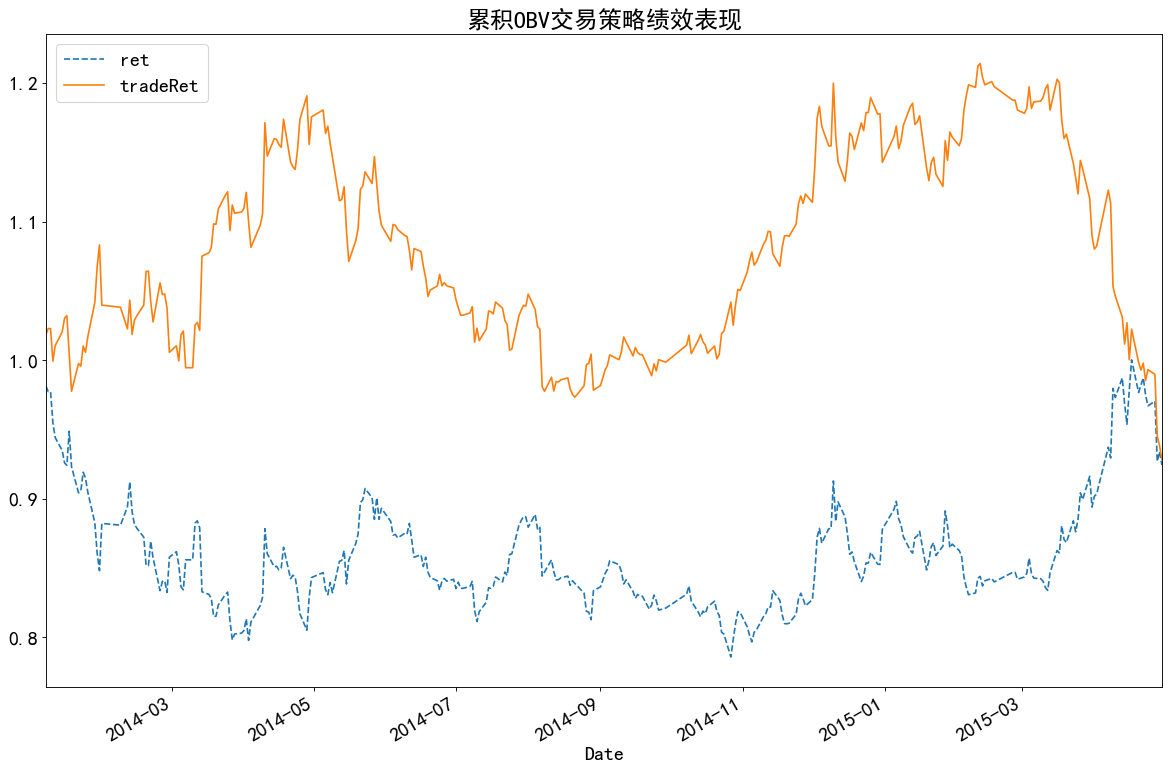

In [17]:
import matplotlib
plt.figure(figsize=(18,12),dpi=80)
matplotlib.rcParams['axes.unicode_minus']=False
plt.rc('font', family='SimHei', size=18)
ret=OBVtrade.ret
tradeRet=OBVtrade.tradeRet
ret.name='BuyAndHold'
tradeRet.name='OBVTrade'
(1+ret).cumprod().plot(label='ret',linestyle='dashed')
(1+tradeRet).cumprod().plot(label='tradeRet')
plt.title('累积OBV交易策略绩效表现')
plt.legend()
plt.show()

In [18]:
def backtest(ret,tradeRet):
    def performance(x):
        winpct=len(x[x>0])/len(x[x!=0])
        annRet=(1+x).cumprod()[-1]**(245/len(x))-1
        sharpe=ffn.calc_risk_return_ratio(x)
        maxDD=ffn.calc_max_drawdown((1+x).cumprod())
        perfo=pd.Series([winpct,annRet,sharpe,maxDD],index=['win rate',
                        'annualized return',\
                        'sharpe ratio','maximum drawdown'])
        return(perfo)
    BuyAndHold=performance(ret)
    OBVTrade=performance(tradeRet)
    return(pd.DataFrame({ret.name:BuyAndHold,\
    tradeRet.name:OBVTrade}))

In [19]:
OBVtest=backtest(ret,tradeRet)
OBVtest

,BuyAndHold,OBVTrade
win rate,0.496815,0.519108
annualized return,-0.058270,-0.055129
sharpe ratio,-0.010179,-0.009199
maximum drawdown,-0.199358,-0.235397


In [20]:
smOBVtrade=trade(smOBV,close)
smOBVtrade.head(n=3)

,ret,tradeRet
Date,,
2014-01-06,-0.018701,0.018701
2014-01-07,-0.004069,0.004069
2014-01-08,0.000000,-0.000000


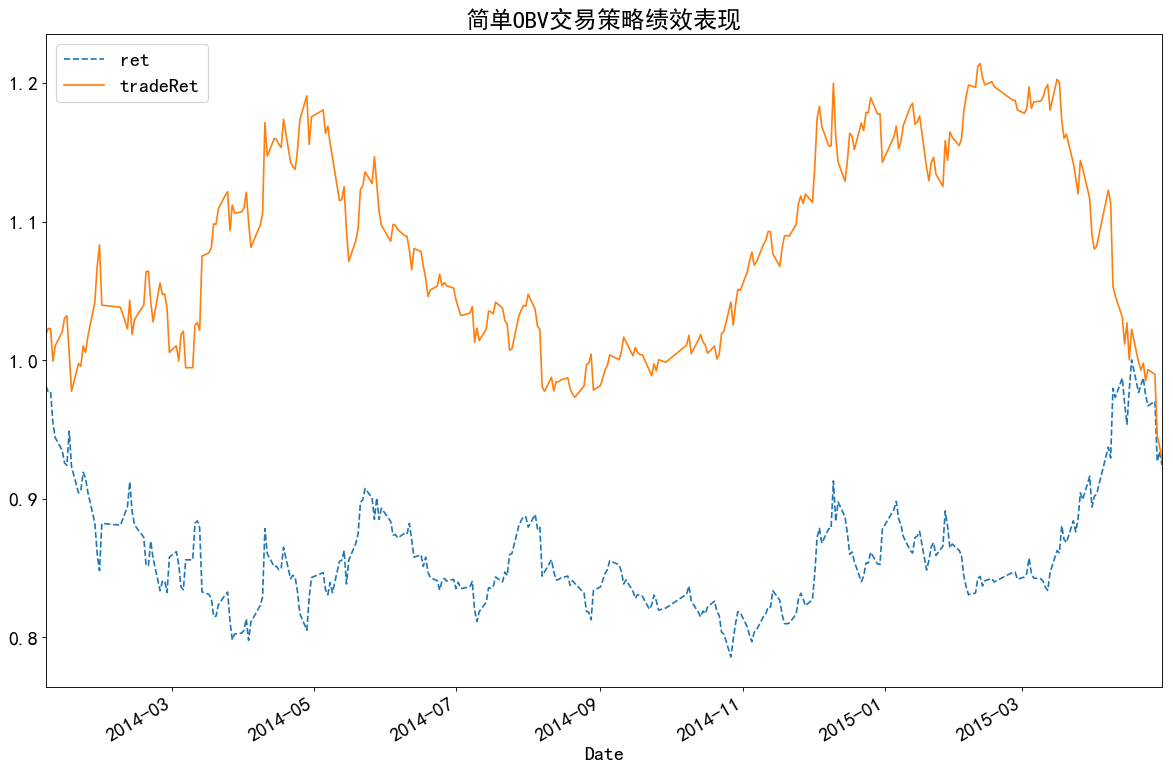

In [21]:
ret=smOBVtrade.ret
ret.name='BuyAndHold'
smtradeRet=smOBVtrade.tradeRet
smtradeRet.name='smOBVTrade'
import matplotlib
plt.figure(figsize=(18,12),dpi=80)
matplotlib.rcParams['axes.unicode_minus']=False
plt.rc('font', family='SimHei', size=18)
(1+ret).cumprod().plot(label='ret',linestyle='dashed')
(1+tradeRet).cumprod().plot(label='tradeRet')
plt.title('简单OBV交易策略绩效表现')
plt.legend()
plt.show()

In [22]:
test=backtest(ret,smtradeRet)
test

,BuyAndHold,smOBVTrade
win rate,0.496815,0.512739
annualized return,-0.058270,0.060095
sharpe ratio,-0.010179,0.023843
maximum drawdown,-0.199358,-0.160496


In [23]:
import os
os.chdir('G:\\freecloud\\ThinkpadC_space\\Desktop\\资料\\资料\量化投资：以Python为工具\\PythonANS')
import pandas as pd
import numpy as np

# 1.使用上海电力股票的交易数据和本章介绍的OBV指标交易策略思路，编写程序实测修正型OBV指标的策略表现

In [64]:
she = pd.read_csv('Data/Part5/008/problem34-1.csv',
                index_col='date')              
she.index.name='Date'
she.index = pd.to_datetime(she.index,format='%Y-%m-%d')

In [65]:
MendOBV = (she.Volume * ((she.Close-she.Low) - (she.High-she.Close))\
        /(she.High - she.Low)).cumsum().dropna()       
signal = pd.Series(np.where(MendOBV.diff()>0 , 1, -1),index = MendOBV.index)[1:]
ret = (she.Close - she.Close.shift(1))/she.Close.shift(1)
OBVret = ret[2:] * signal.shift(1)[1:]

In [66]:
sum(OBVret>0)/len(signal)

0.48589341692789967

In [67]:
dat = pd.concat([signal,she.Close],1).dropna()
dat.columns = ['signal','price']

In [68]:
asset = 10000 * np.ones(len(dat))
cash = 10000 * np.ones(len(dat))
share = np.zeros(len(dat))
for i in range(1,len(dat)):
    cash[i]=cash[i-1]+share[i-1]*dat.price[i]
    asset[i]=cash[i]
    if dat.signal[i-1] == 1:
        share[i]=100
        cash[i]=cash[i]-100*dat.price[i]-100*dat.price[i]*0.0003
    elif dat.signal[i-1] == -1:
        share[i]=-100
        cash[i]=cash[i]+100*dat.price[i]-100*dat.price[i]*0.0003

In [69]:
account=pd.DataFrame({'asset':asset,'cash':cash,'share':share},index=dat.index)

In [70]:
print('修正型OBV策略交易账户收益为: {:.5%}'.format((account.asset[-1]-account.asset[0])/account.asset[0]))

修正型OBV策略交易账户收益为: -1.70961%


E:\Data_analysis_plan\python_36_install\lib\site-packages\pandas\plotting\_core.py:1694: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


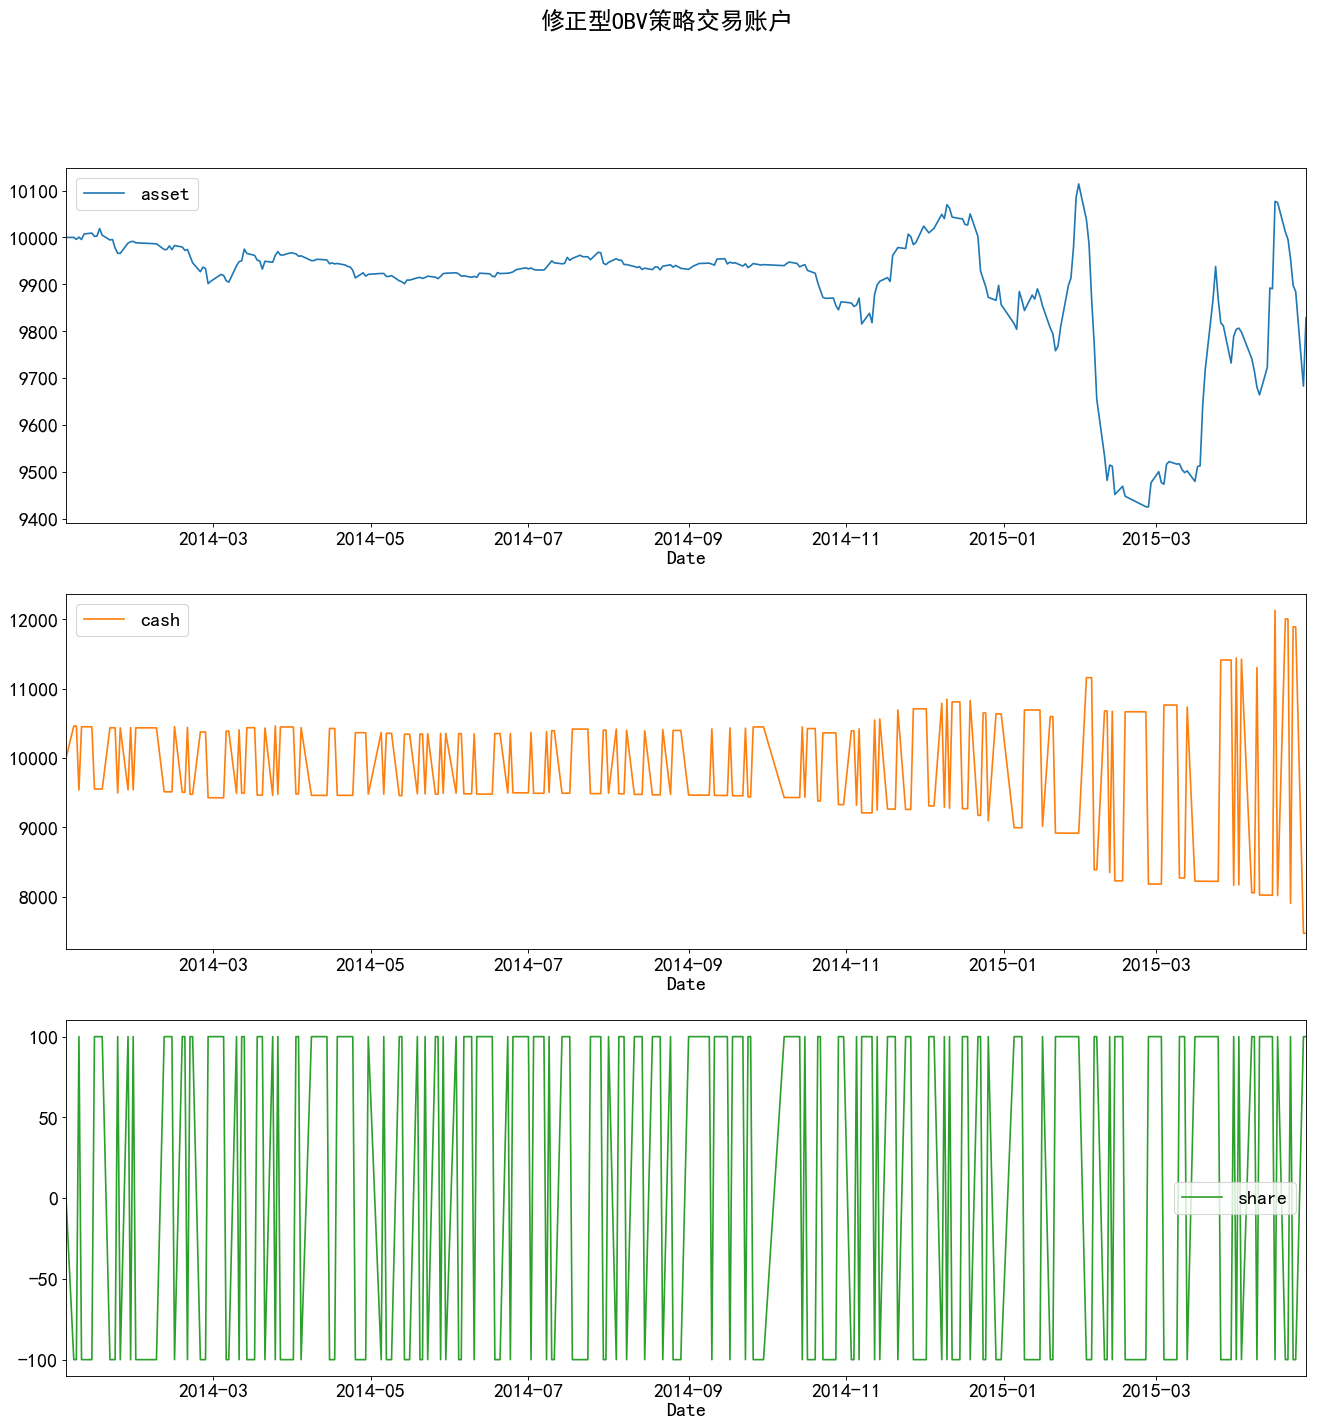

In [71]:
plt.figure(figsize=(20,20),dpi=80)
plt.rc('font', family='SimHei', size=18)
axe1=plt.subplot(111)
#在第一个画面中画出序列的自相关系数图 
plot1=account.plot(subplots=True,\
        title='修正型OBV策略交易账户',ax=axe1)
plt.legend()
plt.show()

# 2.规定当累积OBV由负值转为正值时，市场估价为上涨趋势，释放买入信号；其值由正值转负值时，市场估价处于下降趋势，释放卖出信号.使用青岛啤酒股票的交易数据，编写策略进行实测

In [72]:
difClose = she.Close.diff()

difClose[0] = 0

volume = she.Volume

volume = volume.replace(0, np.nan).dropna()

difClose = difClose[volume.index]

OBV=(((difClose>=0)*2-1) * she.Volume).cumsum()

dat = pd.concat([OBV,she.Close],1).dropna()

dat.columns = ['OBV','price']

asset = 10000 * np.ones(len(dat))

cash = 10000 * np.ones(len(dat))

share = np.zeros(len(dat))

In [73]:
for i in range(2,len(dat)):
    cash[i]=cash[i-1]+share[i-1]*dat.price[i]
    asset[i]=cash[i]
    if dat.OBV[i-2] < 0 and dat.OBV[i-1] > 0:
        share[i]=100
        cash[i]=cash[i]-100*dat.price[i]-100*dat.price[i]*0.0003
    elif dat.OBV[i-2] > 0 and dat.OBV[i-1] < 0:
        share[i]=-100
        cash[i]=cash[i]+100*dat.price[i]-100*dat.price[i]*0.0003

In [74]:
account=pd.DataFrame({'asset':asset,'cash':cash,'share':share},index=dat.index)

In [75]:
print('累积型OBV策略交易账户收益为: {:.5%}'.format((account.asset[-1]-account.asset[0])/account.asset[0]))

累积型OBV策略交易账户收益为: -0.12962%


E:\Data_analysis_plan\python_36_install\lib\site-packages\pandas\plotting\_core.py:1694: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


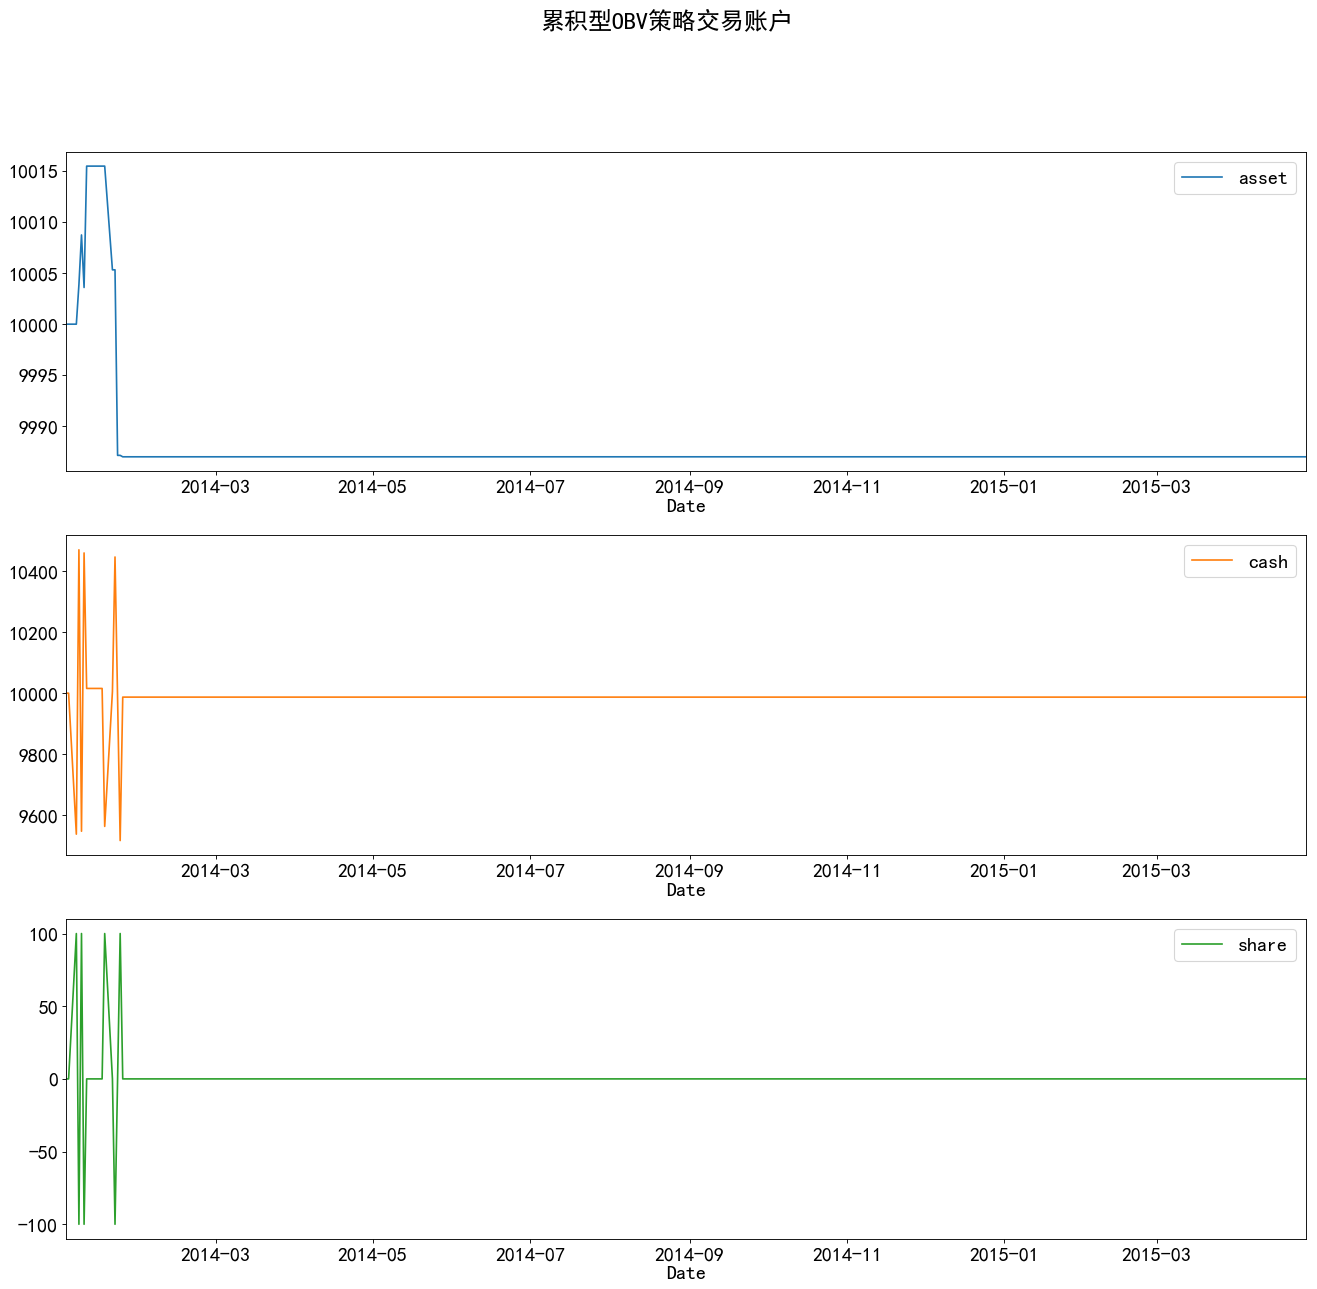

In [76]:
plt.figure(figsize=(20,18),dpi=80)
plt.rc('font', family='SimHei', size=18)
axe1=plt.subplot(111)
#在第一个画面中画出序列的自相关系数图 
plot1=account.plot(subplots=True,\
        title='累积型OBV策略交易账户',ax=axe1)
plt.legend()
plt.show()

# 3.获取万科2013年度日交易数据，计算其12日移动型OBV指标的值

In [77]:
wanke = pd.read_csv('Data/Part5/008/problem34-3.csv',
                index_col='date')
                
wanke.index.name='Date'

In [78]:
wanke.index = pd.to_datetime(wanke.index,format='%Y-%m-%d')

difClose = wanke.Close.diff()

difClose[0] = 0

In [79]:
volume = wanke.Volume

volume = volume.replace(0, np.nan).dropna()

difClose = difClose[volume.index]

OBV=(((difClose>=0)*2-1) * wanke.Volume).cumsum()

In [80]:
smOBV = pd.rolling_mean(OBV,12)

E:\Data_analysis_plan\python_36_install\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  """Entry point for launching an IPython kernel.


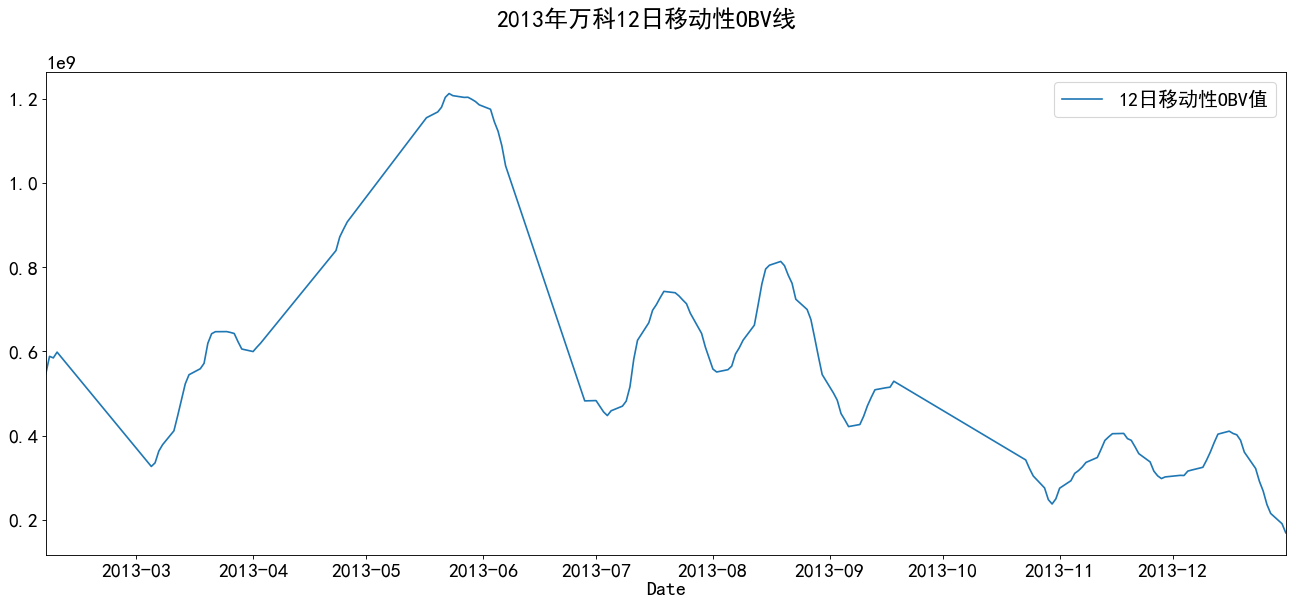

In [82]:
plt.figure(figsize=(20,8),dpi=80)
plt.rc('font', family='SimHei', size=18)
axe1=plt.subplot(111)
#在第一个画面中画出序列的自相关系数图 
plot1=smOBV.dropna().plot(subplots=True,\
        title='2013年万科12日移动性OBV线',label='12日移动性OBV值',ax=axe1)
plt.legend()
plt.show()